In [ ]:
# https://www.tensorflow.org/text/tutorials/transformer
# https://keras.io/examples/nlp/neural_machine_translation_with_transformer
# https://keras.io/examples/vision/image_captioning
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')
APPROACH_NAME = 'SC-CNNxTransformer'

# Check GPU working

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


# Data input pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Thesis Resource/kaggle.json" ~/.kaggle/

!kaggle datasets download -d ngcthunhb/nomna-sr-patches
# !kaggle datasets download -d quandang/nomnaocr
!unzip -q /content/nomna-sr-patches.zip -d /content/NomNaDatasets
# !unzip -q /content/nomnaocr.zip -d /content/Datasets

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/ngcthunhb/nomna-sr-patches
License(s): unknown
100% 2.51G/2.51G [02:21<00:00, 20.0MB/s]
100% 2.51G/2.51G [02:21<00:00, 19.1MB/s]


In [ ]:
!cp /content/NomNaDatasets/NomNaOCR/SR_Patches_Real_ESRGANx2/*.txt /content/TBSRN_Dataset

In [ ]:
DATASET_DIR = r'/content/NomNaDatasets/Patches'
ALL_TRANSCRIPTS_PATH = f'{DATASET_DIR}/All.txt'
VALID_TRANSCRIPTS_PATH = f'{DATASET_DIR}/Validate.txt'
FONT_PATH = r'/content/NomNaDatasets/NomNaTong-Regular.ttf'

## Load and remove records with rare characters

In [ ]:
import os
import re
import numpy as np
import tensorflow as tf

import csv
import tensorflow as tf
from tqdm.auto import tqdm


def ctc_decode(predictions, max_length):
    input_length = tf.ones(len(predictions)) * predictions.shape[1]
    preds_decoded = tf.keras.backend.ctc_decode(
        predictions,
        input_length = input_length,
        greedy = True,
    )[0][0][:, :max_length]

    return tf.where(
        preds_decoded == tf.cast(1, tf.int64),
        tf.cast(-1, tf.int64), # Treat [UNK] token same as blank label
        preds_decoded
    )


def update_tensor_column(tensor, values, col_idx):
    if col_idx < 0: raise ValueError("col_idx must be >= 0")
    rows = tf.range(tf.shape(tensor)[0])
    column = tf.zeros_like(rows) + col_idx
    idxs = tf.stack([rows, column], axis=1)
    return tf.tensor_scatter_nd_update(tensor, idxs, tf.squeeze(values, axis=-1))


def tokens2sparse(batch_tokens):
    idxs = tf.where(tf.logical_and(
        batch_tokens != 0, # For [PAD] token
        batch_tokens != -1 # For blank label if use_ctc_decode
    ))
    return tf.SparseTensor(
        tf.cast(idxs, tf.int64),
        tf.gather_nd(batch_tokens, idxs),
        tf.cast(tf.shape(batch_tokens), tf.int64)
    )


def sparse2dense(tensor, shape):
    tensor = tf.sparse.reset_shape(tensor, shape)
    tensor = tf.sparse.to_dense(tensor, default_value=-1)
    tensor = tf.cast(tensor, tf.float32)
    return tensor


def rec2csv(file_name, patch_list, data_handler, model, use_ctc_decode=False):
    with open(file_name, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        for img_path in tqdm(patch_list):
            image = data_handler.process_image(img_path)
            pred_tokens = model.predict(tf.expand_dims(image, axis=0))
            pred_labels = data_handler.tokens2texts(pred_tokens, use_ctc_decode)
            writer.writerow([img_path, pred_labels[0]])

from string import printable
from collections import defaultdict, Counter


class DataImporter:
    def __init__(self, dataset_dir, labels_path, min_length=4):
        self.img_paths, self.labels = [], []
        with open(labels_path, 'r', encoding='utf-8') as file:
            for line in file:
                img_name, text = line.rstrip('\n').split('\t')
                img_path = os.path.join(dataset_dir, img_name)
                text = text.strip().lower()

                if os.path.getsize(img_path) and len(text) >= min_length and self.is_clean_text(text):
                    self.img_paths.append(img_path)
                    self.labels.append(text)

        assert len(self.img_paths) == len(self.labels), 'img_paths and labels must have same size'
        self.img_paths = np.array(self.img_paths)
        self.labels = np.array(self.labels)
        self.vocabs = dict(Counter(''.join(self.labels)).most_common())
        self.size = len(self.labels)


    def remove_rare_chars(self, threshold=1):
        if threshold < 2: return self
        rare_chars, idxs_to_remove = [], []
        is_satisfy_threshold = True

        # Vocabs need to be sorted (for faster checking)
        for char, freq in reversed(self.vocabs.items()):
            if freq < threshold: rare_chars.append(char)
            else: break

        for idx, label in enumerate(self.labels):
            if any((char in label) for char in rare_chars):
                idxs_to_remove.append(idx)

        # Remove sentences containing rare characters and recalculate the vocab frequencies
        idxs_to_remove = np.array(idxs_to_remove)
        self.img_paths = np.delete(self.img_paths, idxs_to_remove)
        self.labels = np.delete(self.labels, idxs_to_remove)

        assert len(self.img_paths) == len(self.labels), 'img_paths and labels must have same size'
        self.vocabs = dict(Counter(''.join(self.labels)).most_common())
        self.size = len(self.labels)

        # Check if there are still rare characters after removing sentences
        smallest_freq = threshold + 1 # If vocabs is empty, the smallest frequency always > threshold
        if len(self.vocabs) >= 1: smallest_freq = list(self.vocabs.values())[-1]
        return self.remove_rare_chars(threshold) if smallest_freq < threshold else self


    def is_clean_text(self, text):
        not_nom_chars = r'\sáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ'
        pattern = re.compile(f'[{not_nom_chars}{re.escape(printable)}]')
        return not bool(re.search(pattern, text.lower()))


    def __str__(self):
        return (
            f'Samples count (not include Latin letters, numbers, punctuations):'
            f'\n- Number of images found: {len(self.img_paths)}'
            f'\n- Number of labels found: {len(self.labels)}'
            f'\n- Number of unique characters: {len(self.vocabs)}'
            f'\n- Characters present: {self.vocabs}'
        )


class DataHandler:
    def __init__(self, dataset: DataImporter, img_size: tuple, padding_char, start_char='', end_char=''):
        self.img_paths = dataset.img_paths
        self.labels = dataset.labels
        self.vocabs = dataset.vocabs

        self.img_size = img_size
        self.padding_char = padding_char
        self.start_char = start_char
        self.end_char = end_char

        # Mapping characters to integers
        vocabulary = list(self.vocabs)
        print(len(vocabulary))
        if start_char != '' and end_char != '': vocabulary += [start_char, end_char]
        print(len(vocabulary))
        self.char2num = tf.keras.layers.StringLookup(vocabulary=vocabulary, mask_token=padding_char)

        # Mapping integers back to original characters
        self.num2char = tf.keras.layers.StringLookup(
            vocabulary = self.char2num.get_vocabulary(),
            mask_token = padding_char,
            invert = True,
        )

        self.max_length = max([len(label) for label in self.labels])
        self.start_token, self.end_token = None, None
        self.start_concat, self.end_concat = [], []
        mask_idxs = [0, 1] # For [PAD] and [UNK] tokens

        if self.start_char != '' and self.end_char != '':
            self.start_token = self.char2num(start_char)
            self.end_token = self.char2num(end_char)
            self.start_concat = [self.start_token]
            self.end_concat = [self.end_token]
            self.max_length += 2 # For [START] and [END] tokens
            mask_idxs.append(self.start_token)

        # Prevent from generating padding, unknown, or start when using argmax in model.predict
        token_mask = np.zeros([self.char2num.vocab_size()], dtype=bool)
        token_mask[np.array(mask_idxs)] = True
        self.token_mask = token_mask


    def distortion_free_resize(self, image, align_top=True):
        h, w = self.img_size
        image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True, method=tf.image.ResizeMethod.LANCZOS5)

        # Check the amount of padding needed to be done.
        pad_height = h - tf.shape(image)[0]
        pad_width = w - tf.shape(image)[1]
        if pad_height == 0 and pad_width == 0: return image

        # Only necessary if you want to do same amount of padding on both sides.
        if pad_height % 2 != 0:
            height = pad_height // 2
            pad_height_top, pad_height_bottom = height + 1, height
        else:
            pad_height_top = pad_height_bottom = pad_height // 2

        if pad_width % 2 != 0:
            width = pad_width // 2
            pad_width_left, pad_width_right = width + 1, width
        else:
            pad_width_left = pad_width_right = pad_width // 2

        return tf.pad(image, paddings=[
            [0, pad_height_top + pad_height_bottom] if align_top else [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ], constant_values=255) # Pad with white color


    def process_image(self, img_path, img_align_top=True):
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image, 3)
        image = self.distortion_free_resize(image, img_align_top)
        image = tf.cast(image, tf.float32) / 255.0
        return image


    def process_label(self, label):
        label = self.char2num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
        label = tf.concat([self.start_concat, label, self.end_concat], 0)
        label_length = tf.shape(label, tf.int64)[0]
        label = tf.pad(
            label,
            paddings = [[0, self.max_length - label_length]],
            constant_values = 0 # Pad with padding token
        )
        return label


    def prepare_tf_dataset(self, idxs, batch_size, drop_remainder=False, img_align_top=True, use_cache=False):
        self.batch_size = batch_size
        dataset = tf.data.Dataset.from_tensor_slices((self.img_paths[idxs], self.labels[idxs])).map(
            lambda img_path, label: (
                self.process_image(img_path, img_align_top),
                self.process_label(label)
            ), num_parallel_calls = tf.data.AUTOTUNE
        ).batch(batch_size, drop_remainder=drop_remainder)

        # When use .cache(), everything before is saved in the memory. It gives a
        # significant boost in speed but only if you can get your hands on a larger RAM
        if use_cache: dataset = dataset.cache()
        return dataset.prefetch(tf.data.AUTOTUNE)


    def tokens2texts(self, batch_tokens, use_ctc_decode=False):
        batch_texts = []
        if use_ctc_decode:
            batch_tokens = ctc_decode(batch_tokens, self.max_length)

        # Iterate over the results and get back the text
        for tokens in batch_tokens:
            indices = tf.gather(tokens, tf.where(tf.logical_and(
                tokens != 0, # For [PAD] token
                tokens != -1 # For blank label if use_ctc_decode
            )))

            # Convert to string
            text = tf.strings.reduce_join(self.num2char(indices))
            text = text.numpy().decode('utf-8')
            text = text.replace(self.start_char, '').replace(self.end_char, '')
            batch_texts.append(text)
        return batch_texts
dataset = DataImporter(DATASET_DIR, ALL_TRANSCRIPTS_PATH, min_length=1)
print(dataset)

Samples count (not include Latin letters, numbers, punctuations):
- Number of images found: 75672
- Number of labels found: 75672
- Number of unique characters: 7479
- Characters present: {'之': 15046, '以': 9592, '人': 7100, '月': 6892, '十': 6504, '不': 6290, '年': 6024, '帝': 5378, '有': 5082, '二': 4984, '其': 4898, '大': 4624, '日': 4520, '為': 4456, '等': 4164, '爲': 4036, '而': 3946, '國': 3892, '一': 3862, '軍': 3760, '王': 3744, '太': 3742, '公': 3660, '天': 3658, '子': 3584, '三': 3568, '官': 3566, '兵': 3556, '明': 3442, '曰': 3360, '於': 3258, '至': 3250, '使': 3194, '時': 3124, '者': 3122, '阮': 3100, '事': 3042, '臣': 3038, '也': 2996, '黎': 2818, '及': 2768, '文': 2748, '皇': 2718, '上': 2716, '如': 2704, '是': 2598, '行': 2516, '安': 2500, '五': 2480, '士': 2480, '中': 2434, '元': 2414, '四': 2398, '命': 2332, '下': 2330, '自': 2322, '民': 2240, '所': 2226, '宗': 2190, '書': 2094, '州': 2088, '六': 2058, '得': 2056, '道': 2030, '武': 2016, '于': 1998, '生': 1976, '都': 1914, '吏': 1892, '城': 1878, '正': 1844, '将': 1814, '知': 1798, '各': 17

## Data constants and input pipeline

In [ ]:
HEIGHT, WIDTH = 432, 48
PADDING_CHAR = '[PAD]'
START_CHAR = '[START]'
END_CHAR = '[END]'

In [ ]:
data_handler = DataHandler(
    dataset,
    img_size = (HEIGHT, WIDTH),
    padding_char = PADDING_CHAR,
    start_char = START_CHAR,
    end_char = END_CHAR
)

7479
7481


In [ ]:
NUM_VALIDATE = DataImporter(DATASET_DIR, VALID_TRANSCRIPTS_PATH, min_length=1).size
MAX_LENGTH = data_handler.max_length
START_TOKEN = data_handler.start_token
END_TOKEN = data_handler.end_token
VOCAB_SIZE = data_handler.char2num.vocab_size()
BATCH_SIZE = 64

## Visualize the data

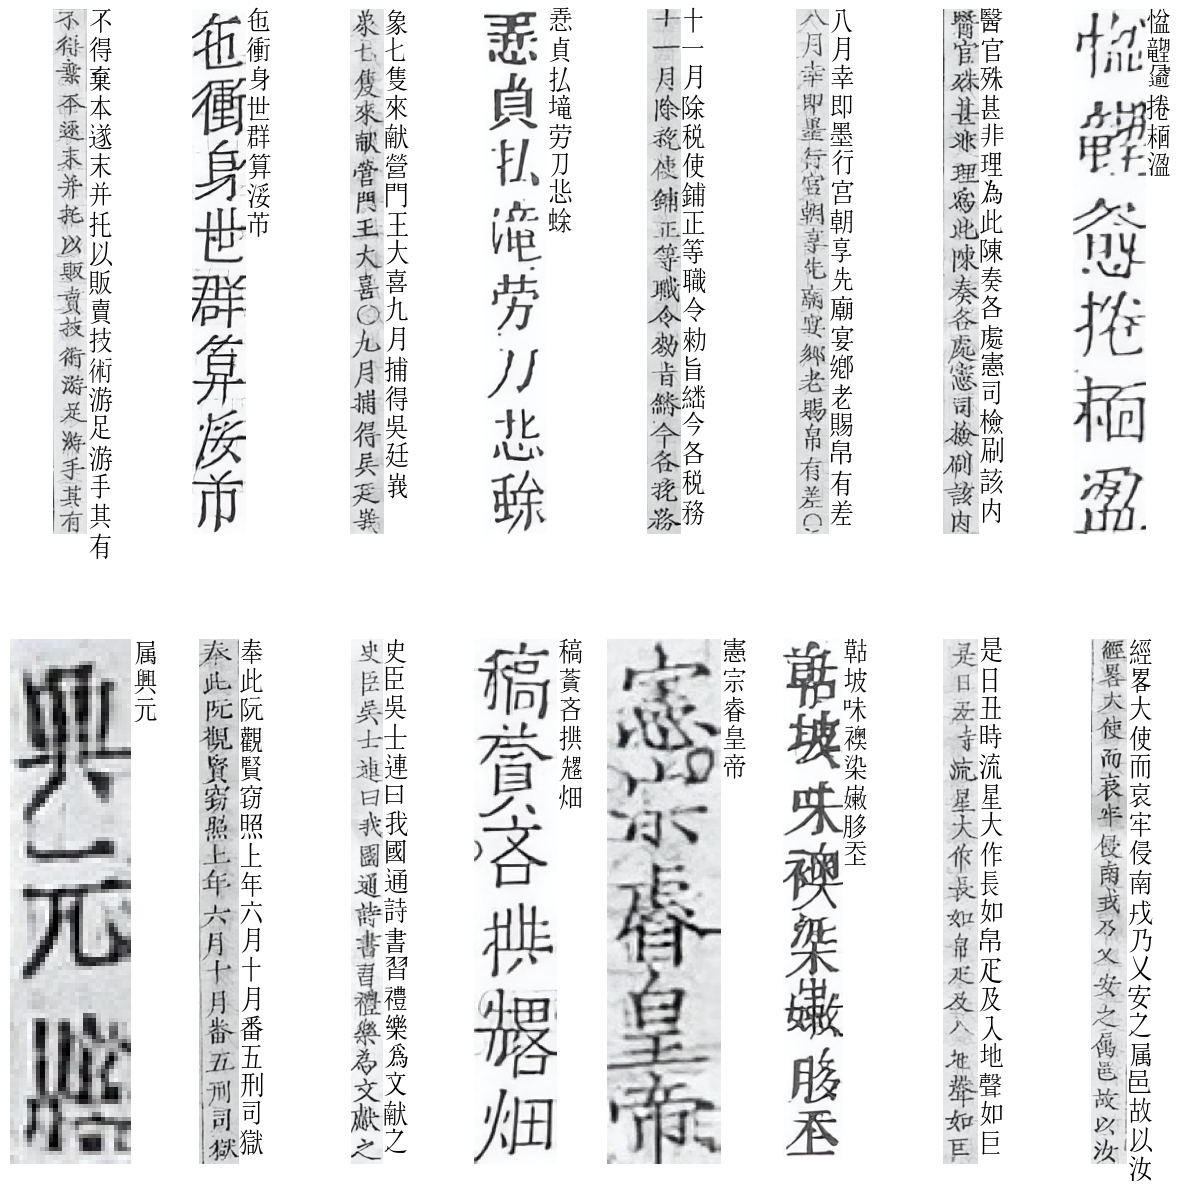

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties


def draw_predicted_text(label, pred_label, fontdict, width, height):
    label = label.replace('[UNK]', '?')
    label_length, pred_length = len(label), len(pred_label)

    if pred_label == label:
        fontdict['color'] = 'green'
        plt.text(width, 0, '\n'.join(pred_label), fontdict=fontdict)
        return

    pred_start, start, end = 0, 0, 0
    while start <= end < label_length:
        text_y = end * height / label_length
        actual_char = '[UNK]' if label[end] == '?' else label[end]

        if label[start:end + 1] in pred_label[pred_start:pred_length]:
            fontdict['color'] = 'dodgerblue'
            plt.text(width, text_y, actual_char, fontdict=fontdict)
        else:
            if end < pred_length and end + 1 < label_length and pred_label[end] == label[end + 1]:
                fontdict['color'] = 'gray'
                plt.text(width, text_y, actual_char, fontdict=fontdict)
            elif end < pred_length:
                fontdict['color'] = 'red'
                plt.text(width, text_y, pred_label[end], fontdict=fontdict)
                fontdict['color'] = 'black'
                plt.text(width * 2, text_y, actual_char, fontdict=fontdict)
            else:
                fontdict['color'] = 'gray'
                plt.text(width, text_y, actual_char, fontdict=fontdict)

            pred_start = end
            start = end + 1
        end += 1


def visualize_images_labels(
    img_paths,
    labels, # shape == (batch_size, max_length)
    pred_labels = None, # shape == (batch_size, max_length)
    figsize = (15, 8),
    subplot_size = (2, 8), # tuple: (rows, columns) to display
    legend_loc = None, # Only for predictions,
    annotate_loc = None, # Only for predictions
    font_path = None
):
    nrows, ncols = subplot_size
    num_of_labels = len(labels)
    assert len(img_paths) == num_of_labels, 'img_paths and labels must have same number of items'
    assert nrows * ncols <= num_of_labels, f'nrows * ncols must be <= {num_of_labels}'
    fontdict = {
        'fontproperties': FontProperties(fname=font_path),
        'fontsize': 18,
        'color': 'black',
        'verticalalignment': 'top',
        'horizontalalignment': 'left'
    }

    plt.figure(figsize=figsize)
    for i in range(min(nrows * ncols, num_of_labels)):
        plt.subplot(nrows, ncols, i + 1)
        image, label = plt.imread(img_paths[i]), labels[i]
        height, width, channel = image.shape
        # print(height, width, channel)
        plt.imshow(image)

        fontdict['color'] = 'black'  # Reset the color
        if pred_labels: draw_predicted_text(label, pred_labels[i], fontdict, width, height)
        else: plt.text(width, 0, '\n'.join(label), fontdict=fontdict)
        plt.axis('off')

    if legend_loc and annotate_loc and pred_labels:
        plt.subplots_adjust(left=0, right=0.75)
        plt.legend(handles=[
            Patch(color='green', label='Full match'),
            Patch(color='dodgerblue', label='Character match'),
            Patch(color='red', label='Wrong prediction'),
            Patch(color='black', label='Actual character'),
            Patch(color='gray', label='Missing position'),
        ], loc=legend_loc)

        annotate_text = [f'{idx + 1:02d}. {text}' for idx, text in enumerate(pred_labels)]
        plt.annotate(
            f'Model predictions:\n{chr(10).join(annotate_text)}',
            fontproperties = FontProperties(fname=font_path),
            xycoords = 'axes fraction',
            fontsize = 14,
            xy = annotate_loc,
        )


def plot_training_results(history, save_name, figsize=(16, 14), subplot_size=(2, 2)):
    nrows, ncols = subplot_size
    if 'lr' in history.keys(): del history['lr']
    assert nrows * ncols <= len(history), f'nrows * ncols must be <= {len(history)}'
    fig = plt.figure(figsize=figsize)

    for idx, name in enumerate(history):
        if 'val' in name: continue
        plt.subplot(nrows, ncols, idx + 1)
        plt.plot(history[name], linestyle='solid', marker='o', color='crimson', label='Train')
        plt.plot(history[f'val_{name}'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel(name, fontsize=14)

        title = name.replace('acc', 'accuracy')\
                    .replace('seq_', 'sequence_')\
                    .replace('char_', 'character_')\
                    .replace('lev_', 'levenshtein_')\
                    .replace('edit_', 'levenshtein_')\
                    .replace('_', ' ').capitalize()
        plt.title(title, fontsize=18)
        plt.legend(loc='best')

    fig.savefig(save_name, bbox_inches='tight')
    plt.show()
visualize_images_labels(
    dataset.img_paths,
    dataset.labels,
    figsize = (15, 15),
    subplot_size = (2, 8),
    font_path = FONT_PATH
)

# Define model components

In [ ]:
from tensorflow.keras.layers import Input
import tensorflow as tf
from tensorflow.keras.layers import (
    Convolution2D, MaxPooling2D, BatchNormalization, Dense, Multiply,
    Activation, LeakyReLU, Reshape, Permute, Lambda, RepeatVector
)


def custom_cnn(config, image_input, alpha=0):
    # Generate Convolutional blocks by config
    for idx, (block_name, block_config) in enumerate(config.items()):
        num_conv, filters, pool_size = block_config.values()
        for conv_idx in range(1, num_conv + 1):
            x = Convolution2D(
                filters = filters,
                kernel_size = (3, 3) if pool_size else (2, 2),
                padding = 'same' if pool_size else 'valid',
                kernel_initializer = 'he_uniform',
                name = f'{block_name}_conv{conv_idx}'
            )(image_input if idx + conv_idx == 1 else x)

            x = BatchNormalization(name=f'{block_name}_bn{conv_idx}')(x)
            if alpha > 0: x = LeakyReLU(alpha, name=f'{block_name}_act{conv_idx}')(x)
            else: x = Activation('relu', name=f'{block_name}_relu{conv_idx}')(x)

        if pool_size is not None:
            x = MaxPooling2D(pool_size, name=f'{block_name}_pool')(x)
    return x


def reshape_features(last_cnn_layer, dim_to_keep=-1, name='cnn_features'):
    # Reshape accordingly before passing the output to the RNN or Transformer
    _, height, width, channel = last_cnn_layer.get_shape()
    if dim_to_keep == 1:
        target_shape = (height, width * channel)
    elif dim_to_keep == 2:
        target_shape = (width, height * channel)
    elif dim_to_keep == 3 or dim_to_keep == -1:
        target_shape = (height * width, channel)
    else:
        raise ValueError('Invalid dim_to_keep value')
    return Reshape(target_shape=(target_shape), name=name)(last_cnn_layer)


# https://pbcquoc.github.io/vietnamese-ocr (Vietnamese blog)
def visual_attention(feature_maps):
    _, timestep, input_dim = feature_maps.shape
    a = Permute((2, 1), name='dim_switching1')(feature_maps)
    a = Dense(timestep, activation='softmax', name='attention_scores')(a)
    a = Lambda(lambda x: tf.reduce_sum(x, axis=1), name='dim_reduction')(a)
    a = RepeatVector(input_dim, name='redistribute')(a)
    a = Permute((2, 1), name='dim_switching2')(a)
    return Multiply(name='context_vector')([feature_maps, a])


class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, name='BahdanauAttention', **kwargs):
        super(BahdanauAttention, self).__init__(name=name, **kwargs)
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, enc_output, hidden):
        # encoder output shape == (batch_size, receptive_size, channels)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, receptive_size, units)
        attention_hidden_layer = self.W1(enc_output) + self.W2(hidden_with_time_axis)
        attention_hidden_layer = tf.nn.tanh(attention_hidden_layer)

        # score shape == (batch_size, receptive_size, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, receptive_size, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, channels)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


class AdditiveAttention(tf.keras.layers.Layer):
    def __init__(self, units, name='AdditiveAttention', **kwargs):
        super(AdditiveAttention, self).__init__(name=name, **kwargs)
        self.W1 = Dense(units, use_bias=False)
        self.W2 = Dense(units, use_bias=False)
        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value):
        w1_query, w2_key = self.W1(query), self.W2(value)
        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key],
            return_attention_scores = True,
        )
        return context_vector, attention_weights

# https://www.tensorflow.org/text/tutorials/transformer
# https://keras.io/examples/nlp/neural_machine_translation_with_transformer
# https://keras.io/examples/vision/image_captioning
# https://medium.com/geekculture/scene-text-recognition-using-resnet-and-transformer-c1f2dd0e69ae
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Add, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import clone_model
# https://www.tensorflow.org/text/tutorials/nmt_with_attention
# https://www.tensorflow.org/tutorials/text/image_captioning
import tensorflow as tf
from tensorflow.keras.models import clone_model
from abc import abstractmethod, ABCMeta # For define pure virtual functions


def get_imagenet_model(model_name, input_shape):
    # Pick a model from https://keras.io/api/applications
    base_model = eval('tf.keras.applications.' + model_name)
    return base_model(input_shape=input_shape, weights=None, include_top=False)


class CustomTrainingModel(tf.keras.Model, metaclass=ABCMeta):
    def __init__(self, data_handler=None, name='CustomTrainingModel', **kwargs):
        super(CustomTrainingModel, self).__init__(name=name, **kwargs)
        self.data_handler = data_handler


    def get_config(self):
        raise NotImplementedError() # To return model components when using clone_model


    @classmethod
    def from_config(cls, config):
        return cls(**config) # To clone model when using kfold training


    @abstractmethod
    def _compute_loss_and_metrics(self, batch, is_training=False):
        pass # Pure virtual functions => Must be overridden in the derived classes


    @abstractmethod
    def predict(self, batch_images):
        pass # Pure virtual functions => Must be overridden in the derived classes


    @tf.function
    def train_step(self, batch):
        with tf.GradientTape() as tape:
            loss, display_results = self._compute_loss_and_metrics(batch, is_training=True)

        # Apply an optimization step
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return display_results


    @tf.function
    def test_step(self, batch):
        _, display_results = self._compute_loss_and_metrics(batch)
        return display_results


    @tf.function
    def _update_metrics(self, batch):
        batch_images, batch_tokens = batch
        predictions = self.predict(batch_images)
        self.compiled_metrics.update_state(batch_tokens, predictions)
        return {m.name: m.result() for m in self.metrics}


    @tf.function
    def _init_seq_tokens(self, batch_size, return_new_tokens=True):
        seq_tokens = tf.fill([batch_size, self.data_handler.max_length], self.data_handler.start_token)
        seq_tokens = tf.cast(seq_tokens, dtype=tf.int64)
        new_tokens = tf.fill([batch_size, 1], self.data_handler.start_token)
        new_tokens = tf.cast(new_tokens, dtype=tf.int64)

        seq_tokens = update_tensor_column(seq_tokens, new_tokens, 0)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        if not return_new_tokens: return seq_tokens, done
        return seq_tokens, new_tokens, done


    @tf.function
    def _update_seq_tokens(self, y_pred, seq_tokens, done, pos_idx, return_new_tokens=True):
        # Set the logits for all masked tokens to -inf, so they are never chosen
        y_pred = tf.where(self.data_handler.token_mask, float('-inf'), y_pred)
        new_tokens = tf.argmax(y_pred, axis=-1)

        # Add batch dimension if it is not present after argmax
        if tf.rank(new_tokens) == 1: new_tokens = tf.expand_dims(new_tokens, axis=1)

        # Once a sequence is done it only produces padding token
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
        seq_tokens = update_tensor_column(seq_tokens, new_tokens, pos_idx)

        # If a sequence produces an `END_TOKEN`, set it `done` after that
        done = done | (new_tokens == self.data_handler.end_token)
        if not return_new_tokens: return seq_tokens, done
        return seq_tokens, new_tokens, done


class EncoderDecoderModel(CustomTrainingModel):
    def __init__(
        self,
        encoder: tf.keras.Model,
        decoder: tf.keras.Model,
        data_handler = None, # DataHandler instance
        dec_rnn_name = '', # Use if there is no rnn in the encoder
        name = 'EncoderDecoderModel',
        **kwargs
    ):
        super(EncoderDecoderModel, self).__init__(data_handler, name, **kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.dec_rnn_name = dec_rnn_name


    def get_config(self):
        return{
            'encoder': clone_model(self.encoder),
            'decoder': clone_model(self.decoder),
            'dec_rnn_name': self.dec_rnn_name,
            'data_handler': self.data_handler
        }


    @tf.function
    def _compute_loss_and_metrics(self, batch, is_training=False):
        batch_images, batch_tokens = batch
        batch_size = batch_images.shape[0]
        loss = tf.constant(0.0)

        dec_input = tf.expand_dims([self.data_handler.start_token] * batch_size, 1)
        if self.dec_rnn_name: # If there is no rnn in encoder, the hidden state will be initialized with 0
            enc_output = self.encoder(batch_images, training=is_training)
            dec_units = self.decoder.get_layer(self.dec_rnn_name).units
            hidden = tf.zeros((batch_size, dec_units), dtype=tf.float32)
        else: enc_output, hidden = self.encoder(batch_images, training=is_training)

        for i in range(1, self.data_handler.max_length):
            # Passing the features through the decoder
            y_pred, hidden, _ = self.decoder([dec_input, enc_output, hidden], training=is_training)
            loss += self.loss(batch_tokens[:, i], y_pred)
            dec_input = tf.expand_dims(batch_tokens[:, i], 1) # Use teacher forcing

        # Update training display result
        metrics = self._update_metrics(batch)
        return loss, {'loss': loss / self.data_handler.max_length, **metrics}


    @tf.function
    def predict(self, batch_images, return_attention=False):
        batch_size = batch_images.shape[0]
        seq_tokens, new_tokens, done = self._init_seq_tokens(batch_size)
        attentions = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

        if self.dec_rnn_name:
            enc_output = self.encoder(batch_images, training=False)
            dec_units = self.decoder.get_layer(self.dec_rnn_name).units
            hidden = tf.zeros((batch_size, dec_units), dtype=tf.float32)
        else: enc_output, hidden = self.encoder(batch_images, training=False)

        for i in range(1, self.data_handler.max_length):
            y_pred, hidden, attention_weights = self.decoder([new_tokens, enc_output, hidden], training=False)
            attentions = attentions.write(i - 1, attention_weights)
            seq_tokens, new_tokens, done = self._update_seq_tokens(y_pred, seq_tokens, done, i)
            if tf.executing_eagerly() and tf.reduce_all(done): break

        if not return_attention: return seq_tokens
        return seq_tokens, tf.transpose(tf.squeeze(attentions.stack()), [1, 0, 2])


class EarlyBindingCaptioner(CustomTrainingModel):
    def __init__(
        self,
        cnn_block: tf.keras.Model,
        rnn_block: tf.keras.Model,
        data_handler = None, # DataHandler instance
        name = 'EarlyBindingCaptioner',
        **kwargs
    ):
        super(EarlyBindingCaptioner, self).__init__(data_handler, name, **kwargs)
        self.cnn_block = cnn_block
        self.rnn_block = rnn_block


    def get_config(self):
        return {
            'cnn_block': clone_model(self.cnn_block),
            'rnn_block': clone_model(self.rnn_block),
            'data_handler': self.data_handler,
        }


    @tf.function
    def _loop(self, batch_images, batch_tokens=None, is_training=False):
        batch_size = batch_images.shape[0]
        seq_tokens, done = self._init_seq_tokens(batch_size, return_new_tokens=False)
        features = self.cnn_block(batch_images, training=is_training)
        loss = tf.constant(0.0)

        for i in range(1, self.data_handler.max_length):
            y_pred = self.rnn_block([seq_tokens[:, :-1], features], training=is_training)
            seq_tokens, done = self._update_seq_tokens(y_pred, seq_tokens, done, i, return_new_tokens=False)
            if batch_tokens is not None: loss += self.loss(batch_tokens[:, i], y_pred) # Is training
            elif tf.executing_eagerly() and tf.reduce_all(done): break # Is predicting

        if batch_tokens is None: return seq_tokens
        return loss / self.data_handler.max_length


    @tf.function
    def _compute_loss_and_metrics(self, batch, is_training=False):
        batch_images, batch_tokens = batch
        loss = self._loop(batch_images, batch_tokens, is_training)
        metrics = self._update_metrics(batch) # Update training display result
        return loss, {'loss': loss, **metrics}


    @tf.function
    def predict(self, batch_images):
        return self._loop(batch_images)


def point_wise_ffn(embedding_dim, feed_forward_units):
    return tf.keras.Sequential([
        Dense(feed_forward_units, activation='relu'), # (batch_size, seq_length, feed_forward_units)
        Dense(embedding_dim) # (batch_size, seq_length, embedding_dim)
    ])


class TransformerEmbedding(tf.keras.layers.Layer):
    def __init__(
        self,
        embedding_dim, # d_model
        seq_length, # For positional embedding => receptive_size if features or max_length - 1 if texts
        vocab_size = None, # If None => Disable tokens embedding, just use positional embedding
        use_scale = True,
        use_pos_embed = False,
        name = 'TransformerEmbedding',
        **kwargs
    ):
        ''' https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11/303
        We'll learn position-embedding vectors the same way we learn to embed word indices.
        We'll then proceed to add our position embeddings to the corresponding word embeddings,
        to obtain a position-aware word embedding. This technique is called "positional embedding".
        '''
        super(TransformerEmbedding, self).__init__(name=name, **kwargs)
        self.tokens_embedding = Embedding(vocab_size, embedding_dim) if vocab_size else None
        self.positions_embedding = Embedding(seq_length, embedding_dim) if use_pos_embed else None
        self.embed_scale = tf.sqrt(tf.cast(embedding_dim, tf.float32)) if use_scale else None
        self.embedding_dim = embedding_dim
        self.seq_length = seq_length


    def call(self, inputs):
        if self.positions_embedding:
            positions = tf.range(start=0, limit=self.seq_length, delta=1)
            positions_info = self.positions_embedding(positions)
        else: positions_info = self.positional_encoding()

        if self.tokens_embedding: inputs = self.tokens_embedding(inputs)
        if self.embed_scale is not None: inputs *= self.embed_scale
        return inputs + positions_info


    def positional_encoding(self):
        pos = np.arange(self.seq_length)[:, np.newaxis]
        i = np.arange(self.embedding_dim)[np.newaxis, :]
        angle_rads = pos / np.power(10000, (2 * (i//2)) / np.float32(self.embedding_dim))
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2]) # Apply sin to even indices in the array; 2i
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2]) # Apply cos to odd indices in the array; 2i+1
        return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)


    def compute_mask(self, inputs, mask=None):
        # This will be propagated to the mask argument when call the TransformerDecoderLayer below
        if self.tokens_embedding: return inputs != 0 # Mask padding token
        return None # Not use masking if just use positional embedding


class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, embedding_dim, feed_forward_units, dropout_rate, name='TransformerEncoderLayer', **kwargs):
        super(TransformerEncoderLayer, self).__init__(name=name, **kwargs)
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate)
        self.ffn = point_wise_ffn(embedding_dim, feed_forward_units)

        # The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the
        # embedding_dim (last) axis. (epsilon: small float added to variance to avoid dividing by 0)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.supports_masking = True


    def call(self, features, training, mask=None):
        attn_output = self.mha(query=features, value=features, key=features, attention_mask=None, training=training)
        out1 = self.layernorm1(features + attn_output)
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2 # (batch_size, receptive_size, embedding_dim)


class TransformerDecoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, embedding_dim, feed_forward_units, dropout_rate, name='TransformerDecoderLayer', **kwargs):
        super(TransformerDecoderLayer, self).__init__(name=name, **kwargs)
        self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate)
        self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate)
        self.ffn = point_wise_ffn(embedding_dim, feed_forward_units)

        # The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the
        # embedding_dim (last) axis. (epsilon: small float added to variance to avoid dividing by 0)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.supports_masking = True


    def call(self, inputs, enc_output, training, mask=None):
        # enc_output.shape == (batch_size, receptive_size, embedding_dim)
        padding_mask = None
        if mask is not None: # Check for the attention mask when use encoder output in MultiHeadAttention
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)

        causal_mask = self.get_causal_attention_mask(inputs)
        look_ahead_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
        look_ahead_mask = tf.minimum(look_ahead_mask, causal_mask)

        attn1, attn_weights_block1 = self.mha1(
            query=inputs, value=inputs, key=inputs, training=training,
            attention_mask=look_ahead_mask, return_attention_scores=True
        ) # (batch_size, max_length - 1, embedding_dim)
        out1 = self.layernorm1(attn1 + inputs)

        attn2, attn_weights_block2 = self.mha2(
            query=out1, value=enc_output, key=enc_output, training=training,
            attention_mask=padding_mask, return_attention_scores=True
        ) # (batch_size, max_length - 1, embedding_dim)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2) # (batch_size, max_length - 1, embedding_dim)
        out3 = self.layernorm3(ffn_output + out2) # (batch_size, max_length - 1, embedding_dim)
        return out3, attn_weights_block1, attn_weights_block2


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, seq_length = input_shape[0], input_shape[1]
        seq_range = tf.range(seq_length)

        mask = tf.cast(seq_range[:, tf.newaxis] >= seq_range, dtype=tf.int32)
        mask = tf.reshape(mask, (1, seq_length, seq_length))
        return tf.tile(mask, tf.concat([
            tf.expand_dims(batch_size, -1),
            tf.constant([1, 1], dtype=tf.int32)
        ], axis=0))


def TransformerEncoderBlock(
    receptive_size, # CNN output features size
    num_layers, # N encoder layers
    num_heads,
    embedding_dim, # d_model
    feed_forward_units, # dff
    dropout_rate,
    use_skip_connection = False,
    name = 'TransformerEncoderBlock'
):
    features_maps = Input(shape=(receptive_size, embedding_dim), dtype='float32', name='cnn_features')
    x = TransformerEmbedding(embedding_dim, receptive_size, name='PositionalEncoding')(features_maps)
    if dropout_rate > 0: x = Dropout(dropout_rate, name='embedding_dropout')(x)

    for i in range(num_layers):
        x = TransformerEncoderLayer(
            num_heads = num_heads,
            embedding_dim = embedding_dim, # d_model
            feed_forward_units = feed_forward_units, # dff
            dropout_rate = dropout_rate,
            name = f'Encoder{i + 1}'
        )(x)

    if use_skip_connection: x = Add(name='skip_connection')([features_maps, x])
    return tf.keras.Model(inputs=features_maps, outputs=x, name=name)


def TransformerDecoderBlock(
    enc_shape, # (receptive_size, enc_channels)
    seq_length, # = max_length - 1, cause the inputs is shifted by 1
    vocab_size,
    num_layers, # N decoder layers
    num_heads,
    embedding_dim, # d_model
    feed_forward_units, # dff
    dropout_rate,
    name = 'TransformerDecoderBlock'
):
    enc_output = Input(shape=enc_shape, dtype='float32', name='encoder_output')
    dec_seq_input = Input(shape=(seq_length,), dtype='int64', name='decoder_sequence')
    attention_weights = {}

    # Adding tokens embedding and positional encoding
    x = TransformerEmbedding(embedding_dim, seq_length, vocab_size, name='TokEmbAndPosEncode')(dec_seq_input)
    if dropout_rate > 0: x = Dropout(dropout_rate, name='embedding_dropout')(x)

    for i in range(num_layers):
        layer_name = f'Decoder{i + 1}'
        x, block1, block2 = TransformerDecoderLayer(
            num_heads = num_heads,
            embedding_dim = embedding_dim, # d_model
            feed_forward_units = feed_forward_units, # dff
            dropout_rate = dropout_rate,
            name = layer_name
        )(x, enc_output)
        attention_weights[f'{layer_name}_block1'] = block1
        attention_weights[f'{layer_name}_block2'] = block2

    y_pred = Dense(vocab_size, name='prediction')(x)
    return tf.keras.Model(inputs=[dec_seq_input, enc_output], outputs=[y_pred, attention_weights], name=name)


class TransformerOCR(CustomTrainingModel):
    def __init__(self, cnn_model, encoder, decoder, data_handler, name='TransformerOCR', **kwargs):
        super(TransformerOCR, self).__init__(data_handler, name, **kwargs)
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder


    def get_config(self):
        return {
            'cnn_model': clone_model(self.cnn_model),
            'encoder': clone_model(self.encoder),
            'decoder': clone_model(self.decoder),
            'data_handler': self.data_handler
        }


    @tf.function
    def _compute_loss_and_metrics(self, batch, is_training=False):
        batch_images, batch_tokens = batch
        features = self.cnn_model(batch_images, training=is_training) # (batch_size, receptive_size, embedding_dim)
        enc_output = self.encoder(features, training=is_training) if self.encoder else features

        dec_seq_input = batch_tokens[:, :-1]
        dec_seq_real = batch_tokens[:, 1:]
        dec_seq_pred, _ = self.decoder([dec_seq_input, enc_output], training=is_training) # (batch_size, seq_length, embedding_dim)

        loss = self.loss(dec_seq_real, dec_seq_pred)
        metrics = self._update_metrics(batch)
        return loss, {'loss': loss, **metrics}


    @tf.function
    def predict(self, batch_images, return_attention=False):
        batch_size = batch_images.shape[0]
        seq_tokens, done = self._init_seq_tokens(batch_size, return_new_tokens=False)
        features = self.cnn_model(batch_images, training=False) # (batch_size, receptive_size, embedding_dim)
        enc_output = self.encoder(features, training=False) if self.encoder else features
        attentions = []

        for i in range(1, self.data_handler.max_length):
            y_pred, attention_weights = self.decoder([seq_tokens[:, :-1], enc_output], training=False)
            attentions.append(attention_weights)
            y_pred = y_pred[:, i - 1, :] # Select last token from seq_length (max_length - 1) dimension (batch_size, 1, vocab_size)
            seq_tokens, done = self._update_seq_tokens(y_pred, seq_tokens, done, i, return_new_tokens=False)
            if tf.executing_eagerly() and tf.reduce_all(done): break

        if not return_attention: return seq_tokens
        return seq_tokens, attentions


## Features extraction

In [ ]:
def get_cnn_model(imagenet_model=None, imagenet_output_layer=None, name='CNN_model'):
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else:
        image_input = Input(shape=(HEIGHT, WIDTH, 3), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)},
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)},
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)},
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (2, 2)},

            # Last Conv blocks with 2x2 kernel but without no padding and pooling layer
            'block5': {'num_conv': 2, 'filters': 512, 'pool_size': None},
        }
        x = custom_cnn(conv_blocks_config, image_input)

    # Reshape accordingly before passing output to the Transformer encoder
    feature_maps = reshape_features(x, dim_to_keep=1)
    return tf.keras.Model(inputs=image_input, outputs=feature_maps, name=name)

In [ ]:
imagenet_model, imagenet_output_layer = None, None
# # Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 3))
# imagenet_output_layer = 'block5_pool'
# imagenet_model.summary(line_length=100)

## Transformer encoder and decoder

In [ ]:
NUM_LAYERS = 2
NUM_HEADS = 1
EMBEDDING_DIM = 512 # d_model
FEED_FORWARD_UNITS = 512 # dff
DROPOUT_RATE = 0.1

In [ ]:
train_idxs = list(range(dataset.size - NUM_VALIDATE))
valid_idxs = list(range(train_idxs[-1] + 1, dataset.size))
print('Number of training samples:', len(train_idxs))
print('Number of validate samples:', len(valid_idxs))

Number of training samples: 60518
Number of validate samples: 15154


In [ ]:
import random
random.seed(2022)
random.shuffle(train_idxs)

# When run on a small RAM machine, you can set use_cache=False to
# not run out of memory but it will slow down the training speed
train_tf_dataset = data_handler.prepare_tf_dataset(train_idxs, BATCH_SIZE, drop_remainder=True)
valid_tf_dataset = data_handler.prepare_tf_dataset(valid_idxs, BATCH_SIZE, drop_remainder=True)

## Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 1e-3, # Change that less than 1e-3, will count as no improvement
    patience = 10, # Stop if no improvement after 5 epochs
    restore_best_weights = True, # Restore weights from the epoch with the best value
    verbose = 1
)

In [ ]:
# https://github.com/FLming/CRNN.tf2/blob/master/crnn/metrics.py
import tensorflow as tf

def ctc_decode(predictions, max_length):
    input_length = tf.ones(len(predictions)) * predictions.shape[1]
    preds_decoded = tf.keras.backend.ctc_decode(
        predictions,
        input_length = input_length,
        greedy = True,
    )[0][0][:, :max_length]

    return tf.where(
        preds_decoded == tf.cast(1, tf.int64),
        tf.cast(-1, tf.int64), # Treat [UNK] token same as blank label
        preds_decoded
    )

def tokens2sparse(batch_tokens):
    idxs = tf.where(tf.logical_and(
        batch_tokens != 0, # For [PAD] token
        batch_tokens != -1 # For blank label if use_ctc_decode
    ))
    return tf.SparseTensor(
        tf.cast(idxs, tf.int64),
        tf.gather_nd(batch_tokens, idxs),
        tf.cast(tf.shape(batch_tokens), tf.int64)
    )


def sparse2dense(tensor, shape):
    tensor = tf.sparse.reset_shape(tensor, shape)
    tensor = tf.sparse.to_dense(tensor, default_value=-1)
    tensor = tf.cast(tensor, tf.float32)
    return tensor

class SequenceAccuracy(tf.keras.metrics.Metric):
    def __init__(
        self,
        use_ctc_decode = False, # Need to decode predictions if CTC loss used,
        name = 'seq_acc',
        **kwargs
    ):
        super(SequenceAccuracy, self).__init__(name=name, **kwargs)
        self.use_ctc_decode = use_ctc_decode
        self.count = self.add_weight(name='count', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, **kwargs):
        batch_size, max_length = tf.shape(y_true)[0], tf.shape(y_true)[1]
        if self.use_ctc_decode: y_pred = ctc_decode(y_pred, max_length)

        # Get a single batch and convert its labels to sparse tensors.
        sparse_true = tokens2sparse(y_true)
        sparse_pred = tokens2sparse(y_pred)

        y_true = sparse2dense(sparse_true, [batch_size, max_length])
        y_pred = sparse2dense(sparse_pred, [batch_size, max_length])

        num_errors = tf.reduce_any(y_true != y_pred, axis=1)
        num_errors = tf.reduce_sum(tf.cast(num_errors, tf.float32))
        total = tf.cast(batch_size, tf.float32)

        self.count.assign_add(total - num_errors)
        self.total.assign_add(total)

    def result(self):
        return tf.math.divide_no_nan(self.count, self.total)

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.count.assign(0)
        self.total.assign(0)


class CharacterAccuracy(tf.keras.metrics.Metric):
    def __init__(
        self,
        use_ctc_decode = False, # Need to decode predictions if CTC loss used,
        name = 'char_acc',
        **kwargs
    ):
        super(CharacterAccuracy, self).__init__(name=name, **kwargs)
        self.use_ctc_decode = use_ctc_decode
        self.count = self.add_weight(name='count', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, **kwargs):
        batch_size, max_length = tf.shape(y_true)[0], tf.shape(y_true)[1]
        if self.use_ctc_decode: y_pred = ctc_decode(y_pred, max_length)

        num_errors = tf.logical_and(y_true != y_pred, y_true != 0)
        num_errors = tf.reduce_sum(tf.cast(num_errors, tf.float32))
        total = tf.reduce_sum(tf.cast(y_true != 0, tf.float32))

        self.count.assign_add(total - num_errors)
        self.total.assign_add(total)

    def result(self):
        return tf.math.divide_no_nan(self.count, self.total)

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.count.assign(0)
        self.total.assign(0)


class LevenshteinDistance(tf.keras.metrics.Metric):
    def __init__(
        self,
        use_ctc_decode = False, # Need to decode predictions if CTC loss used,
        normalize = False, # If True, this becomes Character Error Rate: CER = (S + D + I) / N
        name = 'levenshtein_distance',
        **kwargs
    ):
        super(LevenshteinDistance, self).__init__(name=name, **kwargs)
        self.use_ctc_decode = use_ctc_decode
        self.normalize = normalize
        self.sum_distance = self.add_weight(name='sum_distance', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, **kwargs):
        batch_size, max_length = tf.shape(y_true)[0], tf.shape(y_true)[1]
        if self.use_ctc_decode: y_pred = ctc_decode(y_pred, max_length)

        # Get a single batch and convert its labels to sparse tensors.
        sparse_true = tokens2sparse(y_true)
        sparse_pred = tokens2sparse(y_pred)

        # Explain tf.edit_distance: https://stackoverflow.com/questions/51612489
        edit_distances = tf.edit_distance(sparse_pred, sparse_true, normalize=self.normalize)
        self.sum_distance.assign_add(tf.reduce_sum(edit_distances))
        self.total.assign_add(tf.cast(batch_size, tf.float32))

    def result(self):
        # Computes and returns a scalar value for the metric
        return tf.math.divide_no_nan(self.sum_distance, self.total)

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.sum_distance.assign(0)
        self.total.assign(0)


# https://github.com/solivr/tf-crnn/blob/master/tf_crnn/model.py#L157
# The result of this function is the same as that of the
# LevenshteinDistance metric above with normalize = True
def warp_cer_metric(y_true, y_pred, use_ctc_decode=False):
    ''' How to use:
    from tensorflow.keras.metrics import MeanMetricWrapper
    cer = MeanMetricWrapper(lambda y_true, y_pred: warp_cer_metric(
        y_true, y_pred, use_ctc_decode=True
    ), name='cer')
    '''
    if use_ctc_decode: y_pred = ctc_decode(y_pred, tf.shape(y_true)[1])
    y_true = tf.cast(y_true, tf.int64)

    # Get a single batch and convert its labels to sparse tensors.
    sparse_true = tokens2sparse(y_true)
    sparse_pred = tokens2sparse(y_pred)

    # Explain tf.edit_distance: https://stackoverflow.com/questions/51612489
    edit_distances = tf.edit_distance(sparse_pred, sparse_true, normalize=False)

    # Compute edit distance and total chars count
    sum_distance = tf.reduce_sum(edit_distances)
    count_chars = tf.reduce_sum(tf.cast(y_true != 0, tf.float32))
    return tf.math.divide_no_nan(sum_distance, count_chars, name='cer')


class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, name='ctc_loss', **kwargs):
        super(CTCLoss, self).__init__(name=name, **kwargs)
        self.loss = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        label_length = tf.cast(y_true != 0, tf.int64)
        label_length = tf.expand_dims(tf.reduce_sum(label_length, axis=-1), axis=1)

        batch_length = tf.cast(tf.shape(y_true)[0], tf.int64)
        pred_length = tf.cast(tf.shape(y_pred)[1], tf.int64)
        pred_length *= tf.ones((batch_length, 1), tf.int64)
        return self.loss(y_true, y_pred, pred_length, label_length)


class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self, name='masked_loss', **kwargs):
        super(MaskedLoss, self).__init__(name=name, **kwargs)
        # The padding token need to be 0 for SparseCategoricalCrossentropy
        # See https://stackoverflow.com/questions/63171001 if loss == nan
        self.loss = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    def call(self, y_true, y_pred):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(y_true != 0, tf.float32)
        return tf.math.divide_no_nan(tf.reduce_sum(loss * mask), tf.reduce_sum(mask))
# https://github.com/FLming/CRNN.tf2/blob/master/crnn/metrics.py
import tensorflow as tf

In [ ]:
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam

# Adadelta tends to benefit from higher initial learning rate values compared to
# other optimizers. Here use 1.0 to match the exact form in the original paper
LEARNING_RATE = 1.0
EPOCHS = 100

# Inference

In [ ]:
cnn_model = get_cnn_model(imagenet_model, imagenet_output_layer)
encoder = TransformerEncoderBlock(
    receptive_size = cnn_model.layers[-1].output_shape[-2],
    num_layers = NUM_LAYERS, # N encoder layers
    num_heads = NUM_HEADS,
    embedding_dim = EMBEDDING_DIM, # d_model
    feed_forward_units = FEED_FORWARD_UNITS, # dff
    dropout_rate = DROPOUT_RATE,
    use_skip_connection = True
)
decoder = TransformerDecoderBlock(
    enc_shape = encoder.output_shape[1:], # (receptive_size, enc_channels)
    seq_length = MAX_LENGTH - 1, # The inputs is shifted by 1
    vocab_size = VOCAB_SIZE,
    num_layers = NUM_LAYERS, # N decoder layers
    num_heads = NUM_HEADS,
    embedding_dim = EMBEDDING_DIM, # d_model
    feed_forward_units = FEED_FORWARD_UNITS, # dff
    dropout_rate = DROPOUT_RATE,
)

In [ ]:
!unzip -q "/content/drive/MyDrive/Thesis Resource/NomNaOCR/Data/weights.zip" -d /content/Weights

In [ ]:
cnn_model.load_weights(f'/content/Weights/Text recognition/TransformerOCR/NomNaOCR/NomNaOCR_SC-CNNxTransformer_cnn.h5')
encoder.load_weights(f'/content/Weights/Text recognition/TransformerOCR/NomNaOCR/NomNaOCR_SC-CNNxTransformer_enc.h5')
decoder.load_weights(f'/content/Weights/Text recognition/TransformerOCR/NomNaOCR/NomNaOCR_SC-CNNxTransformer_dec.h5',
    skip_mismatch = True,
    by_name = True,
)

In [ ]:
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.losses import SparseCategoricalCrossentropy
LEARNING_RATE = 1.0
reset_model = TransformerOCR(cnn_model, encoder, decoder, data_handler)
reset_model.compile(
    optimizer = Adadelta(LEARNING_RATE),
    loss = MaskedLoss(),
    metrics = [
        SequenceAccuracy(),
        CharacterAccuracy(),
        LevenshteinDistance(normalize=True)
    ]
)

## On test dataset

In [ ]:
batch_results = []
for idx, (batch_images, batch_tokens) in enumerate(valid_tf_dataset.take(1)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels = data_handler.tokens2texts(batch_tokens)
    pred_tokens, attentions = reset_model.predict(batch_images, return_attention=True)
    pred_labels = data_handler.tokens2texts(pred_tokens)

    batch_results.append({'true': labels, 'pred': pred_labels, 'attentions': attentions})
    visualize_images_labels(
        img_paths = dataset.img_paths[idxs_in_batch],
        labels = labels,
        pred_labels = pred_labels,
        figsize = (11.6, 30),
        subplot_size = (4, 8),
        legend_loc = (3.8, 4.38),
        annotate_loc = (4, 2.75),
        font_path = FONT_PATH,
    )
    print(
        f'Batch {idx + 1:02d}:\n'
        f'- True: {dict(enumerate(labels, start=1))}\n'
        f'- Pred: {dict(enumerate(pred_labels, start=1))}\n'
    )

# Detail evaluation

In [ ]:
import pandas as pd
import os
import csv
import tensorflow as tf
from tqdm import tqdm


class Evaluator:
    def __init__(self, model, dataset_dir, transcripts_path):
        self.model = model
        self.dataset = DataImporter(dataset_dir, transcripts_path, min_length=1)
        self.tf_dataset = None


    def evaluate(self, data_handler, batch_size, drop_remainder=False):
        self.tf_dataset = tf.data.Dataset.from_tensor_slices((self.dataset.img_paths, self.dataset.labels))
        self.tf_dataset = self.tf_dataset.map(
            lambda img_path, label: (
                data_handler.process_image(img_path),
                data_handler.process_label(label)
            ), num_parallel_calls = tf.data.AUTOTUNE
        ).batch(batch_size, drop_remainder=drop_remainder)

        self.data_handler = data_handler
        self.tf_dataset = self.tf_dataset.cache().prefetch(tf.data.AUTOTUNE)
        return self.model.evaluate(self.tf_dataset, return_dict=True)


    def write_csv(self, file_name, use_ctc_decode=False):
        assert self.tf_dataset, "evaluate() method need to be run first"
        with open(file_name, 'w', encoding='utf-8', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['img_paths', 'labels', 'pred_labels'])

            for idx, (batch_images, batch_tokens) in tqdm(enumerate(self.tf_dataset)):
                labels = self.data_handler.tokens2texts(batch_tokens)
                pred_tokens = self.model.predict(batch_images)
                pred_labels = self.data_handler.tokens2texts(pred_tokens, use_ctc_decode)

                batch_size = len(batch_images)
                paths = self.dataset.img_paths[idx * batch_size: (idx + 1) * batch_size]
                paths = ['/'.join(os.path.abspath(path).split(os.path.sep)[-2:]) for path in paths]
                writer.writerows(list(map(list, zip(*[paths, labels, pred_labels]))))
GT10_TRANSCRIPTS_PATH = f'{DATASET_DIR}/Validate_gt10.txt'
LTE10_TRANSCRIPTS_PATH = f'{DATASET_DIR}/Validate_lte10.txt'

In [ ]:
gt10_evaluator = Evaluator(reset_model, DATASET_DIR, GT10_TRANSCRIPTS_PATH)
lte10_evaluator = Evaluator(reset_model, DATASET_DIR, LTE10_TRANSCRIPTS_PATH)
df = pd.DataFrame([
    reset_model.evaluate(valid_tf_dataset, return_dict=True),
    gt10_evaluator.evaluate(data_handler, BATCH_SIZE, drop_remainder=True),
    lte10_evaluator.evaluate(data_handler, BATCH_SIZE, drop_remainder=True),
])
df.index = ['Full']
df